
# PID control of a self-driving car

In this project, a PID controller is designed to control the steering angle of a simulated car so that it can autonomously drive in a test track. My design and results are included in the following which start from a simple PID controller and ends in a compensator design and a throttle speed control for improved autonomous drive at high speeds.

Each component of the PID controller has the following properties:

- P controller: Improves the transient response (i.e. steers the car towards the center of the lane) but can increase the overshoot (crossing the center of the lane and oscillating around it). Generally, higher P gain makes the transient response faster but at the same time more oscillatory.

- D controller: Induces some damping in the transient response which can reduce the oscillations caused by the P controller. This also improves the convergence towards the center of the lane and at the same time considers the rate of change of CTE which adds a little bit of prediction to the control inputs. That is, if CTE is increasing, D controller detects it and adds some proper control input to the P part to consider this rate of change.

- I controller: It generally improves the steady-state response of the system. That is, if there is a steady-state tracking error, the I controller considers the accumulation of the tracking error over time and corrects this long-term error. However, since in this project we are dealing with a dynamically changing reference position for the car, the I controller can easily make the controller unstable and cause large oscillations if not applied carefully. After applying a phase-lead compensator (see the section “Phase-lead compensator design for improved speed and safety” for details), I used a small gain which can correct small drifts of the car to the left and right of the center of the lane and also improves the control of car on the sharp turns. At sharp turns, when the car is driving close to the curbs, the I controller detects a large integral of error and steers the car towards the center.

I first manually adjusted the PD controller gains based on my intuition: K_p = 0.2, K_d = 0.4 which allowed a maximum safe driving speed of ~20 mi/h (see the attached video file PD-20miph.mp4). For higher speeds, I used the techniques that follows and also added an I controller after a slight modification on the gains of the PD controller.

In [1]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
video_output = 'videos/PD-20miph.mp4'
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))

In [2]:
# Code cell containing some programs for analyzing the results
import matplotlib.pyplot as plt
import pylab as pl
import numpy as np
import math
from sklearn.metrics import mean_squared_error


# function for reading the controller test results
def read_data(file_name):
    result_file = open("results/"+file_name, "r")
    lines = result_file.readlines()
    total_samples = len(lines)-2 # data starts from the 3rd row of the file
    err = np.zeros(total_samples)
    steering = np.zeros(total_samples)
    speed = np.zeros(total_samples)  
    
    i = 0
    for line in lines:
        values = line.split("\t")
        if i ==0: # first row includes the P, I, and D control gains
            kp = values[1]
            ki = values[3]
            kd = values[5]
        if i > 1: # starting from the third row, the data is recorded as: CTE, sterring angle, and speed
            err[i-2] = values[0]
            steering[i-2] = values[1]
            speed[i-2] = values[2]
        i = i+1
            
    result_file.close()
    return kp, ki, kd, err, steering, speed

# a function for extracting drive info and plotting them
def plot_results(file_names, titles):
    data_sets = len(file_names)
    for j in range(data_sets):
        kp, ki, kd, err, steering, speed = read_data(file_names[j])
        x = np.arange(0.0, (len(err))*.05, 0.05)
        f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,5))        
        ax1.plot(x,err, label='CTE')
        ax1.set_xlabel("Time (s)")
        ax1.set_ylabel("CTE (m)")
        ax1.set_xlim((min(x),max(x)))
        ax1.set_ylim((-4,4))
       
        ax2.plot(x,steering, 'r', label='steering angle')
        ax2.set_xlabel("Time (s)")
        ax2.set_ylabel("Normalized steering angle command")
        ax2.set_xlim((min(x),max(x)))
        ax2.set_ylim((-1,1))
        ax2.set_title(titles[j])
        
        ax3.plot(x,speed, 'g', label='Speed (mi/h)')
        ax3.set_xlabel("Time (s)")
        ax3.set_ylabel("Speed (mi/h)")
        ax3.set_xlim((min(x),max(x)))
        ax3.set_ylim((0,75))
        pl.show()


# a function for comparing the test results with different metrics    
def compare_results(file_names, titles):
    data_sets = len(file_names)
    avg_err = np.zeros(len(file_names))
    max_err = np.zeros(len(file_names))
    avg_speed = np.zeros(len(file_names))
    max_speed = np.zeros(len(file_names))
    lap_time = np.zeros(len(file_names))
    
    for j in range(data_sets):
        kp, ki, kd, err, steering, speed = read_data(file_names[j])
        print("\n"+titles[j]+":\n")
        avg_err[j] = mean_squared_error(err, np.zeros(len(err)))
        print("Mean squared error (CTE): \t {:.2f}".format(avg_err[j])+" meters")
        max_err[j] = max(abs(err))
        print("Max error (CTE): \t \t {:.2f}".format(max_err[j])+" meters")
        avg_speed[j] = sum(speed)/len(speed)
        print("Average speed: \t \t \t {:.2f}".format(avg_speed[j])+" meters/second")
        max_speed[j] = max(abs(speed))
        print("Max speed: \t \t \t {:.2f}".format(max_err[j])+" meters")
        lap_time[j] = len(err)*0.05
        print("Lap time: \t \t \t {:.2f}".format(lap_time[j])+" seconds")
        print("------------------------------------------------------")
    return avg_err, max_err, avg_speed, max_speed, lap_time

# function for visualization of the metrics
def bar_plots(pid, pid_comp, pid_comp_throttle, label, ticks):
    n_groups = len(pid)
    bar_width = 0.25
    opacity = 0.8
    index = np.arange(n_groups)
    rects1 = plt.bar(index, pid, bar_width,
                     alpha=opacity,
                     color='b',
                     label='PID')

    rects2 = plt.bar(index + bar_width, pid_comp, bar_width,
                     alpha=opacity,
                     color='r',
                     label='PID+Compensator')

    rects3 = plt.bar(index + 2*bar_width, pid_comp_throttle, bar_width,
                         alpha=opacity,
                         color='g',
                         label='PID+Compensator+Throttle')

    plt.xlabel('Control Method')
    plt.ylabel(label)
    plt.title('Comparison of the three control methods')
    plt.xticks(index + bar_width, (ticks))
    plt.legend()

    plt.tight_layout()
    plt.show()    

# Discussion on the limitations of the PID and a solution for improvement

One of the main reasons that the car cannot drive faster than a limited range of speeds with only a simple PID or PD controller is the corrective nature of the these controllers. That is, the CTE (or tracking error) first should occur and then the controller applies a corrective control action to the steering wheel. In other words, the control does not have any information about the sharpness of the curves ahead and hence cannot apply any preemptive control inputs to prevent hitting the curbs on sharp turns. Therefore, the PD controller was only able to control the car at certain low velocity ranges (around 20 mi/h or lower). At such a point, controller gain adjustments reaches a dead end because whenever the control gains are small the controller allows a stable drive on the straight parts of the track (low frequency CTE inputs to the controller) with slow reactions to the sharp curves and whenever the control gains are high, the controller becomes sensitive to the curves but unstable in the straight parts of the track.

One solution, in my opinion, for improving the results is to use frequency domain design techniques to improve the gain margin for the controller and also modify the high frequency components of the controller output. A complete description of this technique requires several details (such a the one presented in (http://www.ece.mcmaster.ca/~davidson/EE3CL4/slides/LeadLagBode_handout.pdf) which I forgo in this report and keep it to the general and simple descriptions according the following. First, I define the low-frequency and high-frequency motion terminology in the current problem according to:

- Low-frequency motion: when the car is driving at low velocities, the curves appear to the controller as CTE with low frequencies (consider and exaggerated case of driving with 10 mi/h in Fig. 1 shown below when the car has enough time to steer and the curves appear to the controller as slow/low-frequency CTE inputs).

- High-frequency motion: when the car is driving at high velocities (e.g. 50 mi/h in Fig. 2 shown below), the curves appear to the controller as CTE with high frequencies (high frequency CTE inputs to the controller.)

A solution is proposed in the following.


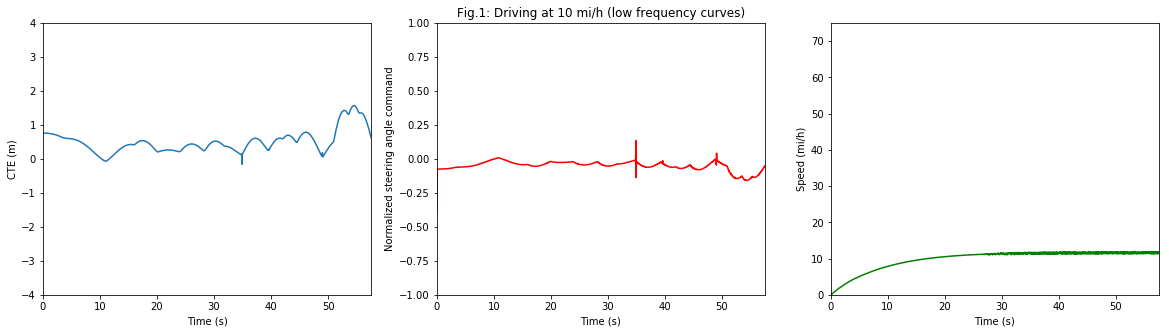

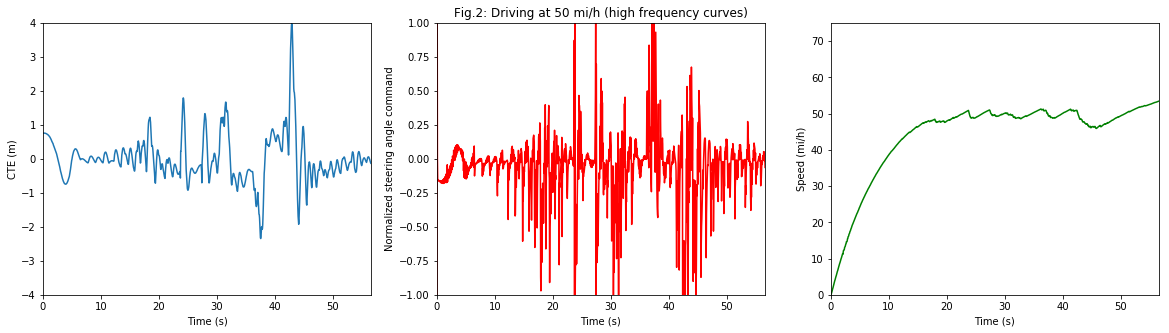

In [3]:
file_names=["low_freq.txt","high_freq.txt"]
titles = ["Fig.1: Driving at 10 mi/h (low frequency curves)", "Fig.2: Driving at 50 mi/h (high frequency curves)"]
plot_results(file_names,titles)

# Phase-lead compensator design for improved speed and safety

In order to improve the frequency response of the car to enable it to drive at higher speeds safely, I designed a phase-lead compensator with the corner frequencies of 5 and 50 rad/s and implemented a digital version with the sampling rate of 20Hz according to the frequency of real-time data coming from the 3D car simulator. In simple words, the phase-lead compensator modifies the outputs of the PID controller with dynamic gains when the input frequency (drive speed) gets higher. That is, the phase-lead only affects the controller outputs in a certain desired range by amplifying their effect (here in 5-50 rad/s) which allows fast maneuvers of the steering angle and hence car on the sharp curves while the low-frequency response still remains stable. The transfer function, in accordance with the aforementioned reference, is 0.5(s/5+1)/(s/50+1) which in the digital (discrete-time) domain follows this generic format

comp_out(k) = c1\*comp_out(k-1)+c2\*comp_in(k)-c3\*comp_in(k-1),

where c1-c3 are constants that depend on the design frequencies and the sampling time of the control loop, k is the time index (i.e. k-1 means the values for the most recent control loop before the current step k), and comp_in and comp_out are the compensator input and output respectively. In this project, comp_in is the output of the PID controller and comp_out is the modified output (steering angle) for a wider range of input frequencies (i.e. driving speeds). In short, the implementation follows this chain:

CTE --> PID controller --> Phase-lead compensator --> steering angle-> car
 
Using this technique, as implemented in the PID.cpp code, and a slight modification of the controller gains, I was able to enable a safe autonomous drive at ~42 mi/h speed which is much larger compared to the 20 mi/h with only a PD controller. Please see PID-42miph.mp4 for this result. The following figures (Fig. 3 and Fig. 4) show the data recorded from the simulator for driving at 42 mi/h speed without (Fig. 3) and with the phase-lead compensator (Fig. 4). It can be easily seen that without using the compensator the car becomes unstable and leaves the track while the compensator allows fast reactions on the steering wheel, when necessary, to keep the car on track.

I further improved the results using another technique as follows.


In [4]:
video_output = 'videos/PID-42miph.mp4'
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))

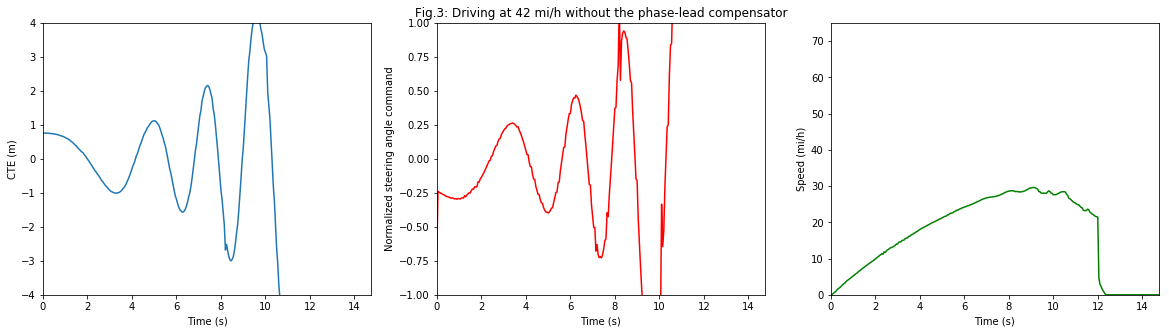

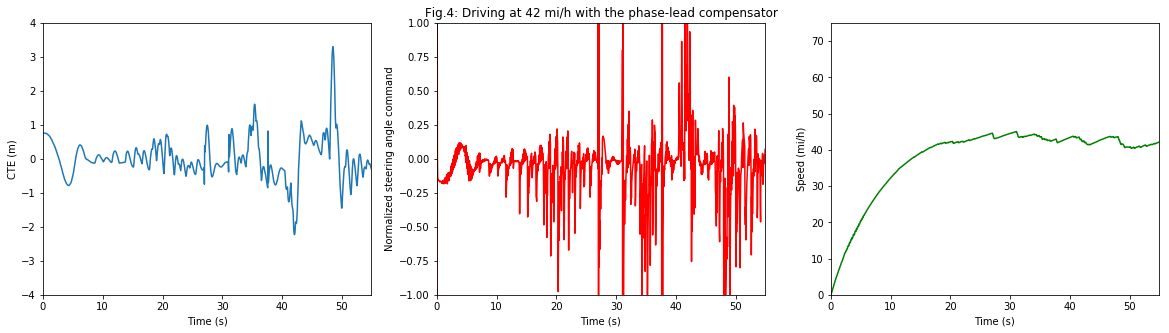

In [5]:
file_names=["42miph-unstable.txt","42miph.txt"]
titles = ["Fig.3: Driving at 42 mi/h without the phase-lead compensator", "Fig.4: Driving at 42 mi/h with the phase-lead compensator"]
plot_results(file_names,titles)

# Throttle command modification
Both of the aforementioned best results (i.e. safe driving at ~20 mi/h with only PID controller and at ~42 mi/h with PID controller and phase-lead compensator) consider a constant driving speed even at the sharp curves. This might not be realistic since intuitively it is safer to drive more slowly when we need to turn sharper. Therefore, in addition to the phase-lead compensator design, I applied a simple modification on the throttle input to the simulator with the following equation:

throttle = 1.0- 2.0*|steering angle command|

where |.| is the absolute value function. With this modification. When the steering angle command coming from the PID controller and compensator is 0 (i.e. driving on a straight lane), throttle takes the maximum value of 1.0 (which means 100 mi/h). On the other hand, when there is a harsh steering angle command (i.e. above 0.5 or below -0.5), the car decelerates (brakes) to maneuver more safely. With this technique, I was able to achieve velocities as high as 65 mi/h at some points on the track. The following figure (Fig. 5) shows results of such a driving condition. Please see the video file high-vel.mp4 in the videos folder of the project for the results. It can be seen in this figure that the car brakes at some points to maneuver more easily and safely. However, there is still some more room for improvement for the throttle control which is far beyond the requirements of this project.

As the last step of the this report, I compare the three best results explained in this report with different metrics in the following.


In [6]:
video_output = 'videos/variable-speed.mp4'
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))

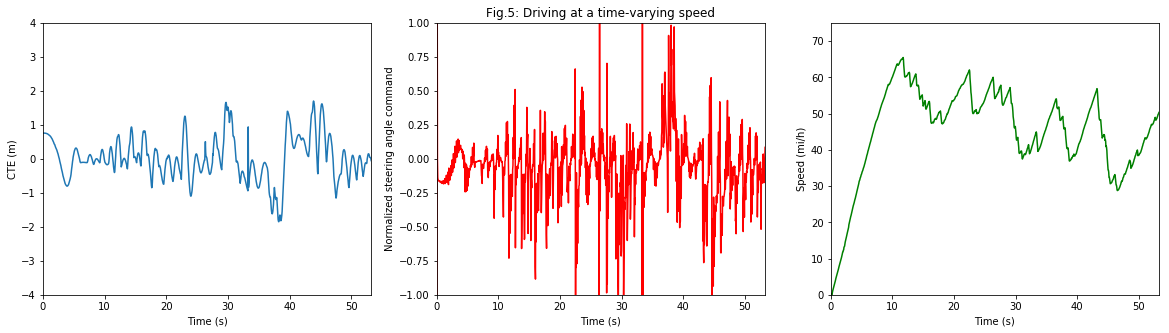

In [7]:
file_names=["variable-speed.txt"]
titles = ["Fig.5: Driving at a time-varying speed"]
plot_results(file_names,titles)

# Comparison of the results

The PID controller, PID+Compensator, and PID+Compensator+Throttle control methods are compared in the following with 5 different metrics: average cross track error (CTE), maximum CTE, average speed, maximum speed, and the lap completion time. Smaller values for average and maximum CTE indicate a safer drive since the car stays closer to the center of the lane.


Comparison of the results for PID, PID+Compensator, and PID+Compensator+Throttle:

PID:

Mean squared error (CTE): 	 0.34 meters
Max error (CTE): 	 	 2.31 meters
Average speed: 	 	 	 18.31 meters/second
Max speed: 	 	 	 2.31 meters
Lap time: 	 	 	 116.15 seconds
------------------------------------------------------

PID+compensator:

Mean squared error (CTE): 	 0.38 meters
Max error (CTE): 	 	 3.30 meters
Average speed: 	 	 	 37.66 meters/second
Max speed: 	 	 	 3.30 meters
Lap time: 	 	 	 54.95 seconds
------------------------------------------------------

PID+compensator+Throttle:

Mean squared error (CTE): 	 0.40 meters
Max error (CTE): 	 	 1.85 meters
Average speed: 	 	 	 45.19 meters/second
Max speed: 	 	 	 1.85 meters
Lap time: 	 	 	 53.30 seconds
------------------------------------------------------


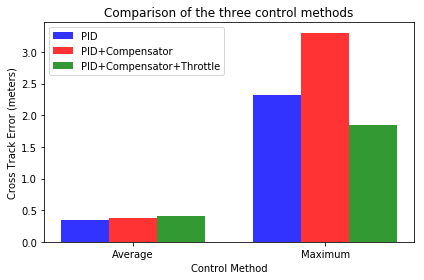

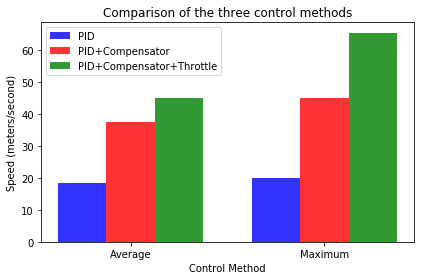

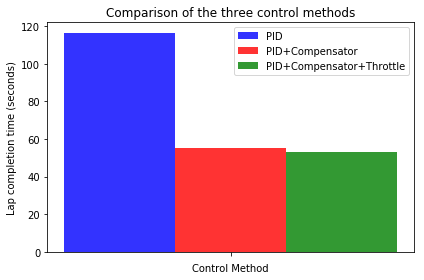

In [8]:
print('Comparison of the results for PID, PID+Compensator, and PID+Compensator+Throttle:')
file_names=["20miph.txt","42miph.txt", "variable-speed.txt"]
titles = ["PID", "PID+compensator", "PID+compensator+Throttle"]
avg_err, max_err, avg_speed, max_speed, lap_time = compare_results(file_names,titles)


pid = [avg_err[0],max_err[0]]
pid_comp = [avg_err[1],max_err[1]]
pid_comp_throttle = [avg_err[2],max_err[2]]
label = "Cross Track Error (meters)"
ticks = ["Average", "Maximum"]
bar_plots(pid,pid_comp,pid_comp_throttle,label,ticks)

pid = [avg_speed[0],max_speed[0]]
pid_comp = [avg_speed[1],max_speed[1]]
pid_comp_throttle = [avg_speed[2],max_speed[2]]
label = "Speed (meters/second)"
bar_plots(pid,pid_comp,pid_comp_throttle,label,ticks)


pid = [lap_time[0]]
pid_comp = [lap_time[1]]
pid_comp_throttle = [lap_time[2]]
label = "Lap completion time (seconds)"
ticks = [" "]
bar_plots(pid,pid_comp,pid_comp_throttle,label,ticks)

# Discussions

From the results, it can be seen that the compensator has a considerable effect on the drive speed and lap completion time since it allows a faster and safer drive compared to the case of only using PID. By comparing the PID+Compensator and PID+Compensator+Throttle we realize that variable speeds including the brakes improves safety of the track by reducing the maximum CTE and also results in a slightly lower lap completion time (1.65 seconds faster using the PID+Compensator+Throttle). 

